# CDG-based Program Clustering

This notebook clusters student programs based on semantic equivalence using the CDG (Cognitive Decision Graph) representation.

**Approach:**
1. Load all programs from CSV
2. Compare each program with existing cluster representatives
3. If equivalent to a cluster, add to it; otherwise create a new cluster
4. Output cluster statistics and groupings


In [1]:
import pandas as pd
from collections import defaultdict
from tqdm import tqdm
from cdg import programs_equivalent, build_cdg, print_cdg


In [2]:
# Load the data
INPUT_CSV = "data/graded/diag1_100_random_batch1.csv"
df = pd.read_csv(INPUT_CSV)
print(f"Loaded {len(df)} programs")
print(f"Columns: {df.columns.tolist()}")


Loaded 100 programs
Columns: ['student_id', 'code', 'grade (fill this out)']


In [3]:
def cluster_programs(df, code_column='code', id_column='student_id'):
    """
    Cluster programs based on semantic equivalence.
    
    Algorithm:
    - For each program, compare with representatives of existing clusters
    - If equivalent, add to that cluster
    - Otherwise, create a new cluster
    
    Returns:
        clusters: List of lists, each inner list contains (student_id, code) tuples
        failed_parses: List of (student_id, code, error) for programs that couldn't be parsed
    """
    clusters = []  # List of [(student_id, code), ...]
    cluster_representatives = []  # One code per cluster for comparison
    failed_parses = []  # Programs that couldn't be parsed
    
    for idx, row in tqdm(df.iterrows(), total=len(df), desc="Clustering programs"):
        student_id = row[id_column]
        code = row[code_column]
        
        # Skip empty codes
        if pd.isna(code) or not code.strip():
            failed_parses.append((student_id, code, "Empty code"))
            continue
        
        # Try to find a matching cluster
        found_cluster = False
        for i, rep_code in enumerate(cluster_representatives):
            is_equiv, reason = programs_equivalent(code, rep_code)
            if is_equiv:
                clusters[i].append((student_id, code))
                found_cluster = True
                break
        
        # If no matching cluster, create a new one
        if not found_cluster:
            # Check if the code can be parsed
            try:
                build_cdg(code)
                clusters.append([(student_id, code)])
                cluster_representatives.append(code)
            except Exception as e:
                failed_parses.append((student_id, code, str(e)))
    
    return clusters, failed_parses


In [4]:
# Run clustering
clusters, failed_parses = cluster_programs(df)

print(f"\n" + "="*60)
print("CLUSTERING RESULTS")
print("="*60)
print(f"Total programs: {len(df)}")
print(f"Number of clusters: {len(clusters)}")
print(f"Failed to parse: {len(failed_parses)}")


Clustering programs: 100%|██████████| 100/100 [00:17<00:00,  5.79it/s]


CLUSTERING RESULTS
Total programs: 100
Number of clusters: 34
Failed to parse: 3


In [5]:
# Cluster size distribution
cluster_sizes = [len(c) for c in clusters]
print("Cluster Size Distribution:")
print(f"  Min size: {min(cluster_sizes)}")
print(f"  Max size: {max(cluster_sizes)}")
print(f"  Mean size: {sum(cluster_sizes)/len(cluster_sizes):.2f}")

# Sort clusters by size (largest first)
clusters_sorted = sorted(enumerate(clusters), key=lambda x: len(x[1]), reverse=True)

print("\nTop 10 Largest Clusters:")
for rank, (cluster_id, cluster) in enumerate(clusters_sorted[:10], 1):
    student_ids = [s[0] for s in cluster]
    print(f"  {rank}. Cluster {cluster_id}: {len(cluster)} programs")
    print(f"     Student IDs: {student_ids[:5]}{'...' if len(student_ids) > 5 else ''}")


Cluster Size Distribution:
  Min size: 1
  Max size: 37
  Mean size: 2.85

Top 10 Largest Clusters:
  1. Cluster 1: 37 programs
     Student IDs: ['3Q7yfPTmBwY24XotEUDSQbDPhcn2', 'euiprXnBDsModVmfCfYnPsm9fBu1', 'z7YmEH6s4Hag7flPAvJ1xQoCB5H2', 'CzXrCvJNqvRa0TipVszq4gh7fwC3', 'bvYuTX2QtIf5PM1Wrbuk20wPVko1']...
  2. Cluster 3: 13 programs
     Student IDs: ['2wLrL7ik4RP0mJ356HyYn9Ahnpz1', 'V1cayw77kvfFWsmQ8CefmPjBeTA3', 'O6cNcKekGgPmOymLN0rEIKFdM4f1', 'BSuzh6SuwzQsMcOiJYW5iTJeazn2', 'InDRn7HQ9AhTCPKwkacFWX5F4DS2']...
  3. Cluster 10: 8 programs
     Student IDs: ['54WbvvuBnLNRgql13PiopcQ9JF02', 'NtPBwP7JwuREuTooA8PdpESmPbH3', 'RRBufMY5bLbZV2Rwm75xBLv9G5J2', 'TesJH7E8jZVPW7A57Vvk8xFw8th1', 'ArBvuOqBo6QrFxQ2dGcP109kdRG3']...
  4. Cluster 9: 3 programs
     Student IDs: ['ud7N8OhplAP9EkXpXWJNfmBFsWn1', 'mEtx8thTCMfZM3zFQRAAhQvqDox1', 'PndpsYhA2shHwvdVKbAt8ZXN9ff2']
  5. Cluster 0: 2 programs
     Student IDs: ['FWMhWHBo9mQCw4fYPeA8GfJPQXO2', 'fAs4qGtu3YfqcXJzT3lsg1UuoVR2']
  6. Cluster 5: 2 

In [9]:
# Show representative code for the largest clusters
print("="*60)
print("REPRESENTATIVE PROGRAMS FROM LARGEST CLUSTERS")
print("="*60)

for rank, (cluster_id, cluster) in enumerate(clusters_sorted[:3], 1):
    print(f"\n--- Cluster {cluster_id} ({len(cluster)} programs) ---")
    print(f"Student IDs: {[s[0] for s in cluster]}")
    print("\nRepresentative code:")
    print(cluster[0][1][:400])
    print("\nCDG representation:")
    print_cdg(cluster[0][1])
    print()


REPRESENTATIVE PROGRAMS FROM LARGEST CLUSTERS

--- Cluster 1 (37 programs) ---
Student IDs: ['3Q7yfPTmBwY24XotEUDSQbDPhcn2', 'euiprXnBDsModVmfCfYnPsm9fBu1', 'z7YmEH6s4Hag7flPAvJ1xQoCB5H2', 'CzXrCvJNqvRa0TipVszq4gh7fwC3', 'bvYuTX2QtIf5PM1Wrbuk20wPVko1', 'asf1t44qDJQ2yBQxAvpnYO9OrDy2', 'XhLyFOBt9za4svXQSq3TF8JYp7N2', 'zb0fhUPfbuWAwd62FcW4P0wPV9v2', 'OVGeqPBBPGZRKf0ceuHknm79UTr2', 'G8Aq3XPbcEafmgCaTVvdOGA0U3i2', 'nhDlMovSbnd0NDVSdb0GZd9eSgn2', '8hee7q9vyXfVRPIQPJbZWyHfeL92', 'U3NSw55CZlNuZN2xqt3Ia18SNeX2', 'h1GMZMCg73ZU9AYFZmZJk3Usz8q2', 'Nh6EiVgztASDczo9v7BmUFOr5cq2', 'UARAHcMYJAYo1hE3FTDVQL8j3K43', '8u5GZzgLBLgLD2XA7xyAYB2ltXm2', 'QWYPpLy6ViVcjXCqxEF6F9XJQM03', '39T0jW7AZFM5WCT1XywFeOk2crR2', 'pFmG15EYgKMHeiVTYtoyZ1hsAHj2', 'MG2p2P9Ehfcs3q8R9RVBTAPqOQI2', 'LbkCHbZoYlY7Lhyy3WsrRWtXZF13', 'OHRKhtaHbLhagHbaVbLBoIDC9dL2', '6XYTGMdEeTRXlocvJpaia8m8gby2', '61K54DJY2ETaEsJweg3gSJm0TC92', 'Oqis9BttzpdgKJ5gR3BUCMtqvxJ2', 'ASL73DhU9KUe3twtlMxPqQ3Znvq2', 'Wx4JRJOYJKcZGrpfHsznJXaiYCT2', 'SMwPpW6Lqy

In [7]:
# Create a summary DataFrame
cluster_summary = []
for cluster_id, cluster in enumerate(clusters):
    student_ids = [s[0] for s in cluster]
    cluster_summary.append({
        'cluster_id': cluster_id,
        'size': len(cluster),
        'student_ids': student_ids
    })

summary_df = pd.DataFrame(cluster_summary)
summary_df = summary_df.sort_values('size', ascending=False).reset_index(drop=True)
print("Cluster Summary (sorted by size):")
summary_df.head(20)


Cluster Summary (sorted by size):


,cluster_id,size,student_ids
0,1,37,"[3Q7yfPTmBwY24XotEUDSQbDPhcn2, euiprXnBDsModVm..."
1,3,13,"[2wLrL7ik4RP0mJ356HyYn9Ahnpz1, V1cayw77kvfFWsm..."
2,10,8,"[54WbvvuBnLNRgql13PiopcQ9JF02, NtPBwP7JwuREuTo..."
3,9,3,"[ud7N8OhplAP9EkXpXWJNfmBFsWn1, mEtx8thTCMfZM3z..."
4,18,2,"[ppWABJF5M2b3CilAWK1Tle1RQih2, BOOXwnwj1pdrQAu..."
5,16,2,"[h6GlmC5P9ETgs5nDOdQmIYM6gVQ2, C24p0hPKs1R0tiZ..."
6,25,2,"[EHhPwcRZDze6PAVWSCE1QP2Kwgc2, lq9YyDYdpjbHDIm..."
7,13,2,"[4unWvixFsyenYrIVzhhx4OSqpaI2, h3y8BbCkTcPf19i..."
8,0,2,"[FWMhWHBo9mQCw4fYPeA8GfJPQXO2, fAs4qGtu3YfqcXJ..."
9,5,2,"[vSIljt43RrWTDllCpyNfHBXAJuZ2, 6zIfqGobKSbZgE6..."


In [8]:
summary_df.to_csv("results/analysis/cdg_cluster_batch1.csv")

In [10]:
# Create a mapping: student_id -> cluster_id
student_to_cluster = {}
for cluster_id, cluster in enumerate(clusters):
    for student_id, code in cluster:
        student_to_cluster[student_id] = cluster_id

# Add cluster assignment to original dataframe
df['cluster_id'] = df['student_id'].map(student_to_cluster)
print("DataFrame with cluster assignments:")
df[['student_id', 'cluster_id']].head(20)


DataFrame with cluster assignments:


,student_id,cluster_id
0,FWMhWHBo9mQCw4fYPeA8GfJPQXO2,0.0
1,3Q7yfPTmBwY24XotEUDSQbDPhcn2,1.0
2,euiprXnBDsModVmfCfYnPsm9fBu1,1.0
3,OIwVtuci3aRUB44HqGUEt23KrYp2,2.0
4,2wLrL7ik4RP0mJ356HyYn9Ahnpz1,3.0
5,V1cayw77kvfFWsmQ8CefmPjBeTA3,3.0
6,z7YmEH6s4Hag7flPAvJ1xQoCB5H2,1.0
7,CzXrCvJNqvRa0TipVszq4gh7fwC3,1.0
8,bvYuTX2QtIf5PM1Wrbuk20wPVko1,1.0
9,BeBIa0bvrfTRLHfHvsbwWzZYCUD3,4.0


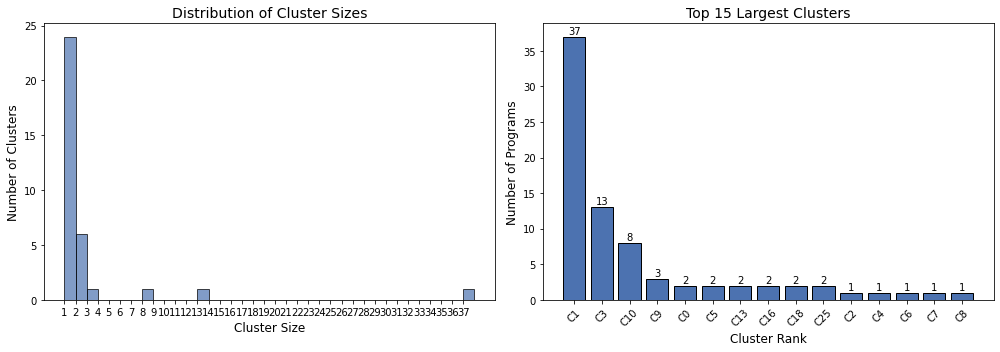

In [13]:
# Visualize cluster size distribution
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Histogram of cluster sizes
ax1 = axes[0]
ax1.hist(cluster_sizes, bins=range(1, max(cluster_sizes)+2), edgecolor='black', alpha=0.7, color='#4C72B0')
ax1.set_xlabel('Cluster Size', fontsize=12)
ax1.set_ylabel('Number of Clusters', fontsize=12)
ax1.set_title('Distribution of Cluster Sizes', fontsize=14)
ax1.set_xticks(range(1, max(cluster_sizes)+1))

# Bar chart of top clusters
ax2 = axes[1]
top_n = min(15, len(clusters))
top_cluster_ids = [c[0] for c in clusters_sorted[:top_n]]
top_cluster_sizes = [len(c[1]) for c in clusters_sorted[:top_n]]
bars = ax2.bar(range(top_n), top_cluster_sizes, color='#4C72B0', edgecolor='black')
ax2.set_xlabel('Cluster Rank', fontsize=12)
ax2.set_ylabel('Number of Programs', fontsize=12)
ax2.set_title(f'Top {top_n} Largest Clusters', fontsize=14)
ax2.set_xticks(range(top_n))
ax2.set_xticklabels([f'C{i}' for i in top_cluster_ids], rotation=45)

# Add value labels on bars
for bar, size in zip(bars, top_cluster_sizes):
    ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.1, 
             str(size), ha='center', va='bottom', fontsize=10)

plt.savefig('results/analysis/clustering_result.png')
plt.tight_layout()
plt.show()


In [11]:
# Show failed parses if any
if failed_parses:
    print(f"Failed to parse {len(failed_parses)} programs:")
    for student_id, code, error in failed_parses[:5]:
        print(f"  - Student {student_id}: {error}")
else:
    print("All programs parsed successfully!")


Failed to parse 3 programs:
  - Student zLuuqyzAowN8Rm080rwOQFP15nq2: Syntax error in code: invalid syntax (<unknown>, line 8)
  - Student cLqjRj5fWTdUXvB0hrzwDiNzNVj2: Syntax error in code: unexpected indent (<unknown>, line 11)
  - Student WZdyhe5RKGVYSYbScQ7l6ZN6AnM2: Syntax error in code: EOL while scanning string literal (<unknown>, line 4)


## Final Summary


In [12]:
print("="*60)
print("FINAL SUMMARY")
print("="*60)
print(f"Total programs analyzed: {len(df)}")
print(f"Successfully clustered: {len(df) - len(failed_parses)}")
print(f"Failed to parse: {len(failed_parses)}")
print()
print(f"Number of unique program patterns: {len(clusters)}")
print()

# Singleton vs multi-program clusters
singletons = sum(1 for s in cluster_sizes if s == 1)
multi_program = len(clusters) - singletons

print(f"Singleton clusters (unique programs): {singletons}")
print(f"Multi-program clusters: {multi_program}")
print(f"Programs in multi-program clusters: {sum(s for s in cluster_sizes if s > 1)}")
print()
print(f"Largest cluster has {max(cluster_sizes)} programs")
print(f"This represents {max(cluster_sizes)/len(df)*100:.1f}% of all programs")


FINAL SUMMARY
Total programs analyzed: 100
Successfully clustered: 97
Failed to parse: 3

Number of unique program patterns: 43

Singleton clusters (unique programs): 34
Multi-program clusters: 9
Programs in multi-program clusters: 63

Largest cluster has 29 programs
This represents 29.0% of all programs
